In [42]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(corrplot)
library(ggplot2)

In [4]:
url <- 'https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2024-04-28/data/listings.csv.gz'
buenos <- read_csv(url)

#check col types
str(buenos)

Rows: 36561 Columns: 75
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (25): listing_url, source, name, description, neighborhood_overview, pi...
dbl  (38): id, scrape_id, host_id, host_listings_count, host_total_listings_...
lgl   (7): host_is_superhost, host_has_profile_pic, host_identity_verified, ...
date  (5): last_scraped, host_since, calendar_last_scraped, first_review, la...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [36,561 × 75] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ id                                          : num [1:36561] 111501 111934 11508 117548 14222 ...
 $ listing_url                                 : chr [1:36561] "https://www.airbnb.com/rooms/111501" "https://www.airbnb.com/rooms/111934" "https://www.airbnb.com/rooms/11508" "https://www.airbnb.com/rooms/117548" ...
 $ scrape_id                                   : num [1:36561] 2.02e+13 2.02e+13 2.02e+13 2.02e+13 2.02e+13 ...
 $ last_scraped                                : Date[1:36561], format: "2024-04-29" "2024-04-29" ...
 $ source                                      : chr [1:36561] "city scrape" "city scrape" "city scrape" "city scrape" ...
 $ name                                        : chr [1:36561] "Sunny Apartment Palermo Boulevard Cerviño" "Bright Studio at Palermo Soho" "Amazing Luxurious Apt-Palermo Soho" "Palermo, Buenos Aires: Complete flat: \"Alma Mia\"." ...
 $ description                                 :

In [5]:
#check % lacking data
missing_data_percent <- buenos %>%
  summarise(across(everything(), ~ sum(is.na(.)) / n() * 100)) %>%
  pivot_longer(everything(), names_to = "column", values_to = "percent_missing") %>%
  filter(percent_missing > 0) %>%
  arrange(desc(percent_missing))

print(missing_data_percent)

# A tibble: 26 × 2
   column                       percent_missing
   <chr>                                  <dbl>
 1 neighbourhood_group_cleansed           100  
 2 calendar_updated                       100  
 3 license                                 98.8
 4 neighborhood_overview                   49.1
 5 neighbourhood                           49.1
 6 host_about                              47.4
 7 host_neighbourhood                      36.6
 8 host_location                           23.0
 9 review_scores_accuracy                  18.9
10 review_scores_checkin                   18.9
# ℹ 16 more rows


In [6]:
# remove columns
buenos <- buenos %>%
  select(-calendar_updated, -neighbourhood_group_cleansed, -license)

In [7]:
# convert to numeric vals 'price','host_response_rate','host_acceptance_rate'
buenos <- buenos %>%
  mutate(price = as.numeric(gsub("[$,]", "", price)))

buenos <- buenos %>%
  mutate(host_response_rate = as.numeric(gsub("%", "", host_response_rate)) / 100,
         host_acceptance_rate = as.numeric(gsub("%", "", host_acceptance_rate)) / 100)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `host_response_rate = as.numeric(gsub("%", "",
  host_response_rate))/100`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [11]:
sapply(buenos[, c('price', 'host_response_rate', 'host_acceptance_rate')], class)

price   host_response_rate host_acceptance_rate 
           "numeric"            "numeric"            "numeric"

In [12]:
unique(buenos$bathrooms_text)

[1] "1 bath"            "1.5 baths"         "1.5 shared baths" 
 [4] "2 baths"           NA                  "5.5 baths"        
 [7] "1 shared bath"     "2.5 baths"         "3 baths"          
[10] "0 baths"           "2 shared baths"    "1 private bath"   
[13] "6 baths"           "2.5 shared baths"  "5 baths"          
[16] "4 baths"           "3.5 baths"         "4 shared baths"   
[19] "6 shared baths"    "3 shared baths"    "0 shared baths"   
[22] "3.5 shared baths"  "Private half-bath" "Half-bath"        
[25] "9 baths"           "8 shared baths"    "4.5 baths"        
[28] "Shared half-bath"  "5.5 shared baths"  "7 baths"          
[31] "4.5 shared baths"  "22 baths"          "7 shared baths"   
[34] "6.5 shared baths"  "10 baths"          "9.5 baths"        
[37] "16 baths"          "7.5 baths"         "13 baths"         
[40] "8 baths"           "8.5 shared baths"  "7.5 shared baths" 
[43] "6.5 baths"         "5 shared baths"    "9 shared baths"   
[46] "12.5 baths"        "8.5 baths"         "15 baths"         
[49] "20 baths"

In [13]:
# change half into 0.5
buenos <- buenos %>%
  mutate(bathrooms_text = gsub("(?i)HALF", "0.5", bathrooms_text, perl=TRUE))

In [14]:
unique(buenos$bathrooms_text)

[1] "1 bath"           "1.5 baths"        "1.5 shared baths" "2 baths"         
 [5] NA                 "5.5 baths"        "1 shared bath"    "2.5 baths"       
 [9] "3 baths"          "0 baths"          "2 shared baths"   "1 private bath"  
[13] "6 baths"          "2.5 shared baths" "5 baths"          "4 baths"         
[17] "3.5 baths"        "4 shared baths"   "6 shared baths"   "3 shared baths"  
[21] "0 shared baths"   "3.5 shared baths" "Private 0.5-bath" "0.5-bath"        
[25] "9 baths"          "8 shared baths"   "4.5 baths"        "Shared 0.5-bath" 
[29] "5.5 shared baths" "7 baths"          "4.5 shared baths" "22 baths"        
[33] "7 shared baths"   "6.5 shared baths" "10 baths"         "9.5 baths"       
[37] "16 baths"         "7.5 baths"        "13 baths"         "8 baths"         
[41] "8.5 shared baths" "7.5 shared baths" "6.5 baths"        "5 shared baths"  
[45] "9 shared baths"   "12.5 baths"       "8.5 baths"        "15 baths"        
[49] "20 baths"

In [21]:
# take nums from bathroom_text into bathroom
buenos <- buenos %>%
  mutate(bathrooms_text = gsub("[^0-9.]", "", bathrooms_text))

In [22]:
unique(buenos$bathrooms_text)

[1] "1"    "1.5"  "2"    NA     "5.5"  "2.5"  "3"    "0"    "6"    "5"   
[11] "4"    "3.5"  "0.5"  "9"    "8"    "4.5"  "7"    "22"   "6.5"  "10"  
[21] "9.5"  "16"   "7.5"  "13"   "8.5"  "12.5" "15"   "20"

In [25]:
# convert to num
buenos <- buenos %>%
  mutate(bathrooms_text = gsub("[^0-9.]", "", bathrooms_text)) %>%
  mutate(bathrooms_text = as.numeric(bathrooms_text))

In [36]:
# N/A imputation
selected_cols <- buenos %>%
  select(price, review_scores_rating, review_scores_accuracy, review_scores_cleanliness,
         review_scores_checkin, review_scores_location, review_scores_value,
         host_response_rate, host_acceptance_rate)

medians <- sapply(selected_cols, median, na.rm = TRUE)
medians

price      review_scores_rating    review_scores_accuracy 
                 30598.00                      4.88                      4.91 
review_scores_cleanliness     review_scores_checkin    review_scores_location 
                     4.84                      4.96                      4.94 
      review_scores_value        host_response_rate      host_acceptance_rate 
                     4.84                      1.00                      0.99

In [38]:
selected_cols_imputed <- selected_cols %>%
  mutate(across(c(price, review_scores_rating, review_scores_accuracy, review_scores_cleanliness,
                  review_scores_checkin, review_scores_location, review_scores_value,
                  host_response_rate, host_acceptance_rate),
                ~ifelse(is.na(.), medians[match(cur_column(), names(medians))], .)))

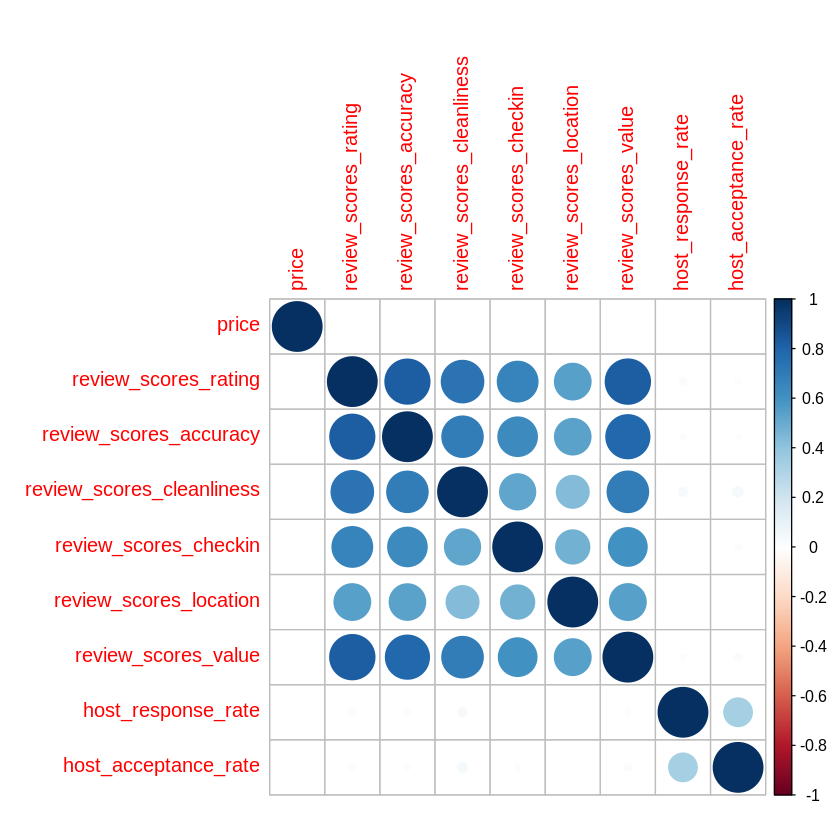

In [40]:
# corr analysis
correlation_matrix <- cor(selected_cols_imputed)

corrplot(correlation_matrix, method = "circle")

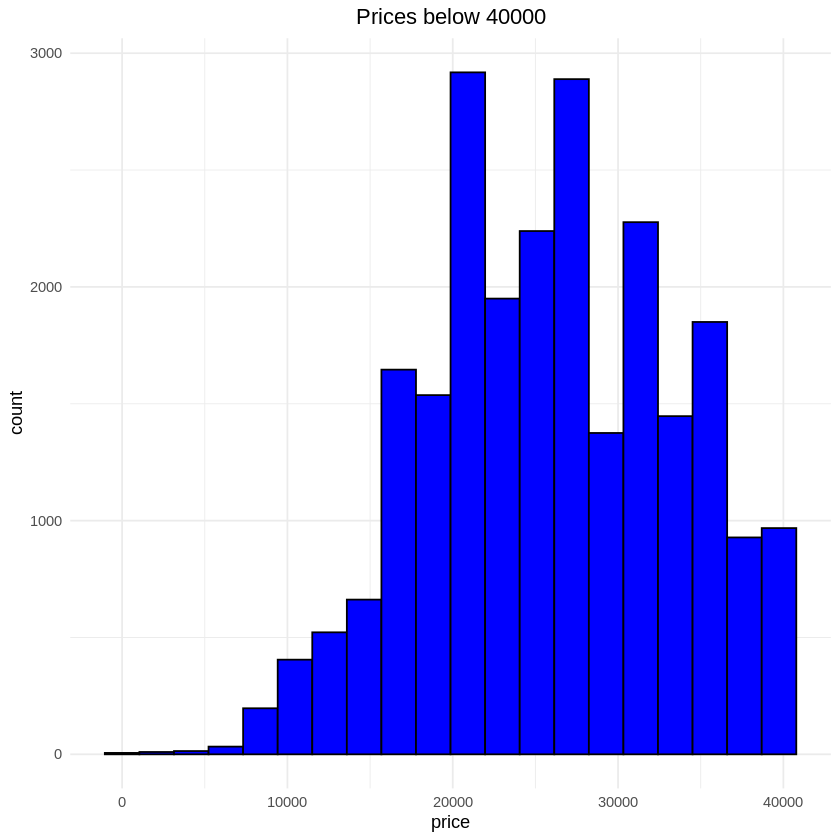

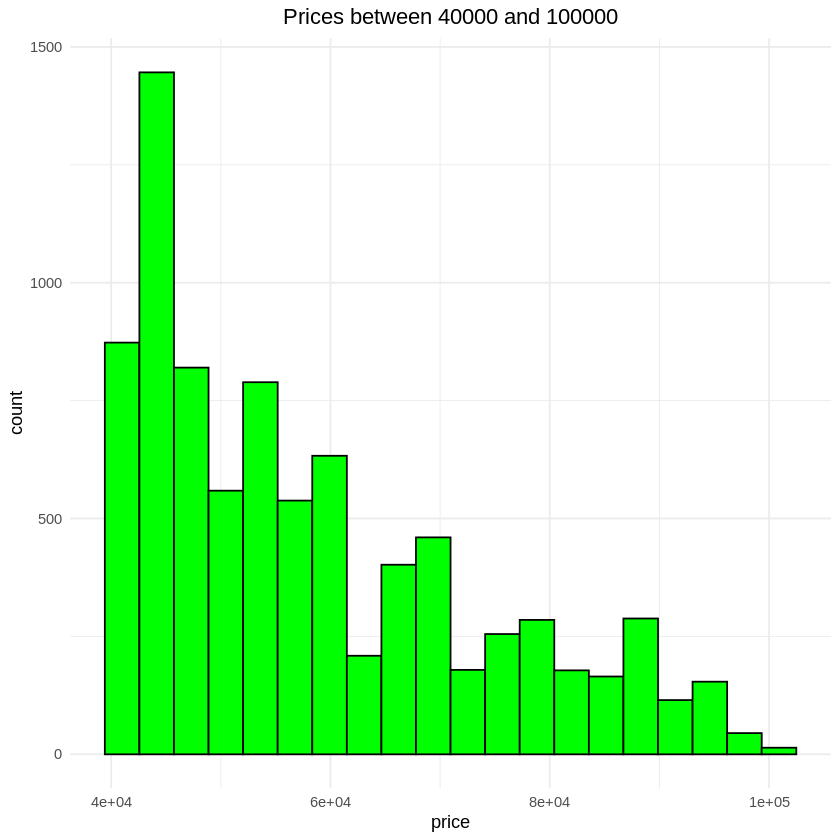

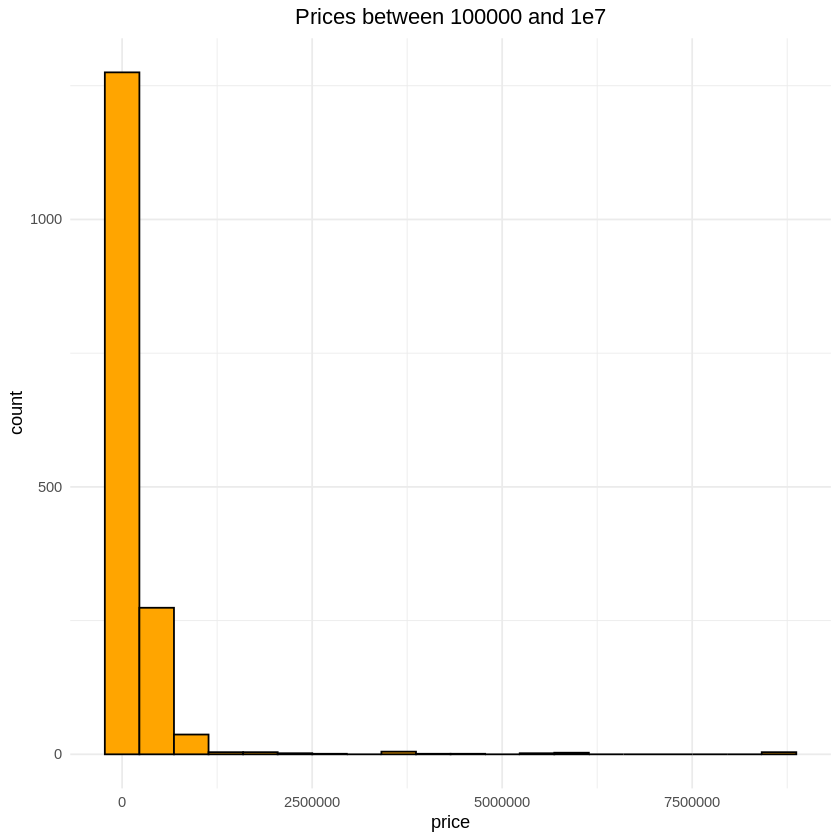

In [43]:
# price dist
buenos %>%
  filter(price < 40000) %>%
  ggplot(aes(x = price)) +
  geom_histogram(bins = 20, fill = "blue", color = "black") +
  labs(title = "Prices < 40000") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

buenos %>%
  filter(price >= 40000 & price < 100000) %>%
  ggplot(aes(x = price)) +
  geom_histogram(bins = 20, fill = "green", color = "black") +
  labs(title = "Prices between 40000 and 100000") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

buenos %>%
  filter(price >= 100000 & price < 1e7) %>%
  ggplot(aes(x = price)) +
  geom_histogram(bins = 20, fill = "orange", color = "black") +
  labs(title = "Prices between 100000 and 1e7") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

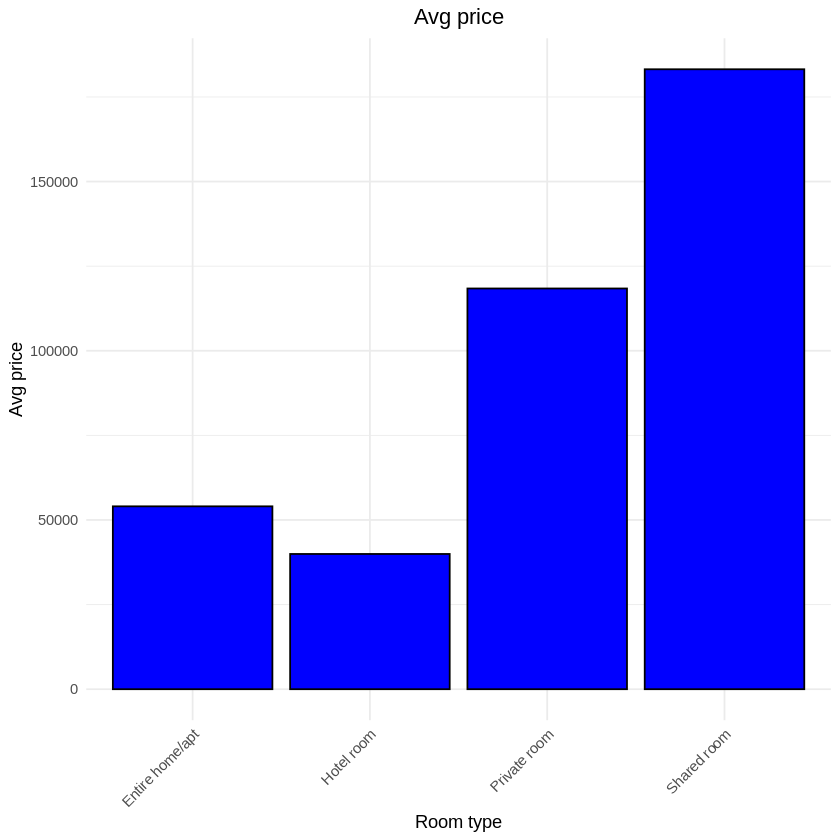

In [58]:
# price over room types

buenos$room_type <- as.factor(buenos$room_type)


mean_prices <- buenos %>%
  group_by(room_type) %>%
  summarise(mean_price = mean(price, na.rm = TRUE))

ggplot(mean_prices, aes(x = room_type, y = mean_price)) +
  geom_bar(stat = "identity", fill = "blue", color = "black") +
  labs(title = "Avg price", x = "Room type", y = "Avg price") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, hjust = 1))